In [1]:
#Importing packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
#from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from skimage import exposure
from imblearn.over_sampling import SMOTE
from skimage.feature import hog
from tqdm import tqdm

In [2]:
#Loading the pickle file containing a dictionary with 
#patient ID and image ID for keys and the cleaned images for values 
#(from the Data Wrangling notebook).
folder_path = '/kaggle/input/rsna-breast-cancer-detection-data-wrangling/'

with open(folder_path + 'cleaned_images.pickle', 'rb') as file:
    img_dict = pickle.load(file)
    
#Loading the cleaned csv file (also from the Data Wrangling notebook).
df = pd.read_csv(folder_path + 'cleaned_data.csv')

# One-hot encoding

This step has already been done back in the Data Wrangling notebook. To check this, we list the column names of df and also the first few rows of df below. Columns such as 'cancer_0', 'cancer_1', 'implant_0', 'implant_1' etc. were created with get_dummies.

In [3]:
df.columns

Index(['Unnamed: 0', 'site_id', 'patient_id', 'image_id', 'age', 'machine_id',
       'laterality_L', 'laterality_R', 'view_CC', 'view_MLO', 'cancer_0',
       'cancer_1', 'biopsy_0', 'biopsy_1', 'invasive_0', 'invasive_1',
       'BIRADS_0.0', 'BIRADS_1.0', 'BIRADS_2.0', 'implant_0', 'implant_1',
       'density_A', 'density_B', 'density_C', 'density_D',
       'difficult_negative_case_False', 'difficult_negative_case_True'],
      dtype='object')

In [4]:
df.head()

,Unnamed: 0,site_id,patient_id,image_id,age,machine_id,laterality_L,laterality_R,view_CC,view_MLO,...,BIRADS_1.0,BIRADS_2.0,implant_0,implant_1,density_A,density_B,density_C,density_D,difficult_negative_case_False,difficult_negative_case_True
0,0,1,10038,1967300488,60.0,216,1,0,0,1,...,1,0,1,0,0,0,1,0,1,0
1,1,1,10038,2142944869,60.0,216,1,0,1,0,...,1,0,1,0,0,0,1,0,1,0
2,2,1,10038,850559196,60.0,216,0,1,0,1,...,1,0,1,0,0,0,1,0,1,0
3,3,1,10038,1350492010,60.0,216,0,1,1,0,...,1,0,1,0,0,0,1,0,1,0
4,4,1,10042,102733848,51.0,93,1,0,1,0,...,1,0,1,0,0,0,1,0,1,0


# Feature engineering with HOG and undersampling

Before using a scaler, we need to decide how to use the pixel values as features. Instead of directly using the pixel values, we will use features created by HOG (histogram of oriented gradients).

Also, because the data is very imbalanced (the mammograms with cancer represent only 4 percent of all mammograms), we will use both undersampling and oversampling. In the cells below, we undersample by collecting all mammograms with cancer and collecting 5 times as many mammograms without cancer (and throw away the rest of the mammograms without cancer).

In [5]:
df_cancer = df[df['cancer_1']==1].reset_index()
df_no_cancer = df[df['cancer_1']==0].reset_index()
print(df_cancer.shape)
print(df_no_cancer.shape)

(662, 28)
(22972, 28)


In [6]:
X = []

for i in tqdm(range(len(df_cancer))):
    key = str(df_cancer['patient_id'][i]) + '/' + str(df_cancer['image_id'][i])
    
    resized_img = img_dict[key].resize((275,275))
    #arr = np.array(resized_img).ravel()
    arr = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    
    arr = np.append(arr, df_cancer['age'][i])
    arr = np.append(arr, df_cancer['laterality_L'][i])
    arr = np.append(arr, df_cancer['view_CC'][i])
    arr = np.append(arr, df_cancer['biopsy_0'][i])
    arr = np.append(arr, df_cancer['implant_0'][i])
    arr = np.append(arr, df_cancer['invasive_0'][i])
    arr = np.append(arr, df_cancer['BIRADS_0.0'][i])
    arr = np.append(arr, df_cancer['BIRADS_1.0'][i])
    arr = np.append(arr, df_cancer['BIRADS_2.0'][i])
    arr = np.append(arr, df_cancer['density_A'][i])
    arr = np.append(arr, df_cancer['density_B'][i])
    arr = np.append(arr, df_cancer['density_C'][i])
    arr = np.append(arr, df_cancer['difficult_negative_case_False'][i])

    X.append(arr)
    
for i in tqdm(range(5*len(df_cancer))):
    key = str(df_no_cancer['patient_id'][i]) + '/' + str(df_no_cancer['image_id'][i])
    
    resized_img = img_dict[key].resize((275,275))
    #arr = np.array(resized_img).ravel()
    arr = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    
    arr = np.append(arr, df_no_cancer['age'][i])
    arr = np.append(arr, df_no_cancer['laterality_L'][i])
    arr = np.append(arr, df_no_cancer['view_CC'][i])
    arr = np.append(arr, df_no_cancer['biopsy_0'][i])
    arr = np.append(arr, df_no_cancer['implant_0'][i])
    arr = np.append(arr, df_no_cancer['invasive_0'][i])
    arr = np.append(arr, df_no_cancer['BIRADS_0.0'][i])
    arr = np.append(arr, df_no_cancer['BIRADS_1.0'][i])
    arr = np.append(arr, df_no_cancer['BIRADS_2.0'][i])
    arr = np.append(arr, df_no_cancer['density_A'][i])
    arr = np.append(arr, df_no_cancer['density_B'][i])
    arr = np.append(arr, df_no_cancer['density_C'][i])
    arr = np.append(arr, df_no_cancer['difficult_negative_case_False'][i])
    
    X.append(arr)

100%|██████████| 3310/3310 [02:23<00:00, 23.09it/s]


Our Y dataframe (consisting of the labels) is:

In [7]:
Y = []

for i in range(len(df_cancer)):
    Y.append(df_cancer['cancer_1'][i])
    
for i in range(5*len(df_cancer)):
    Y.append(df_no_cancer['cancer_1'][i])

# Train-test split

We split the data into a train and a test set, with train_size set to 0.5 so that half of the data goes to train and half goes to test.

In [8]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size = 0.5, random_state = 13)

In [9]:
print(len(Xtrain), len(Xtest), len(Ytrain), len(Ytest))

1986 1986 1986 1986


# Oversampling with SMOTE

We now use SMOTE to oversample the minority class. We will end up with a balanced train dataset in the end (with the same number of mammograms with cancer as without cancer).

In [10]:
sm = SMOTE(random_state = 2, k_neighbors = 3)
Xtrain, Ytrain = sm.fit_resample(Xtrain, Ytrain)

In [11]:
print(len(Xtrain),len(Ytrain))
print(Ytrain.count(0))
print(Ytrain.count(1))

3326 3326
1663
1663


# Scaling

We scale the train data with MinMaxScaler.

In [12]:
scaler = MinMaxScaler()
scaler.fit(Xtrain)
Xtrain_scaled = scaler.transform(Xtrain)

In [13]:
Xtest_scaled = scaler.transform(Xtest)

# PCA

Finally, we use the PCA transformation to reduce the dimensionality of the data.

In [14]:
pca = PCA()
Xtrain_pca = pca.fit(Xtrain_scaled)

Text(0, 0.5, 'Cumulative ratio variance')

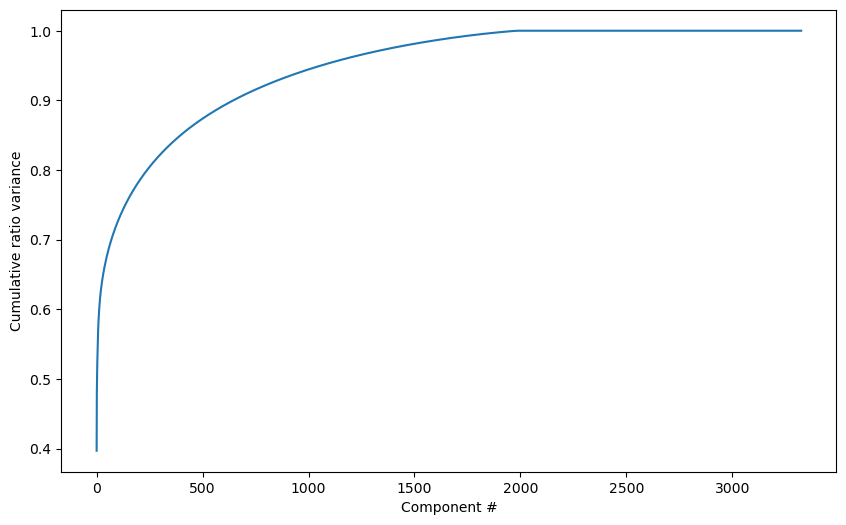

In [15]:
#Plot the cumulative variance ratio with number of components.
plt.subplots(figsize=(10, 6))
plt.plot(Xtrain_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')

We will choose the number of PCA components to be 500, which corresponds to a cumulative ratio variance of around 0.8.

In [16]:
pca = PCA(n_components=100)
pca.fit(Xtrain_scaled)
Xtrain_scaled_pca = pca.transform(Xtrain_scaled)
Xtest_scaled_pca = pca.transform(Xtest_scaled)

In [17]:
print(len(Xtrain_scaled_pca[0]))
print(len(Xtest_scaled_pca[0]))

100
100


We save Xtrain_scaled_pca, Ytrain, Xtest_scaled_pca, Ytest into pickle files.

In [18]:
#Saving Xtrain_scaled_pca, Ytrain, Xtest_scaled_pca, Ytest as pickle files.

fileObj = open('Xtrain_scaled_pca.pickle', 'wb')
pickle.dump(Xtrain_scaled_pca,fileObj)
fileObj.close()

fileObj2 = open('Ytrain.pickle', 'wb')
pickle.dump(Ytrain,fileObj2)
fileObj2.close()

fileObj3 = open('Xtest_scaled_pca.pickle', 'wb')
pickle.dump(Xtest_scaled_pca,fileObj3)
fileObj3.close()

fileObj4 = open('Ytest.pickle', 'wb')
pickle.dump(Ytest,fileObj4)
fileObj4.close()